In [1]:
# import libraries
import numpy as np
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to combine files into a single DataFrame
def combine(files, folder_path=""):
    """
    Combines multiple Divvy trip data files into a single DataFrame.

    Args:
        files (list): List of filenames to combine.
        folder_path (str): Path to the folder containing the files.

    Returns:
        pd.DataFrame: Combined DataFrame.
    """
    combined_df = pd.concat(
        [pd.read_csv(os.path.join(folder_path, file)) for file in files],
        ignore_index=True
    )
    return combined_df

In [3]:
import pandas as pd
import os

# List of filenames
divvy_files = [
    "202201-divvy-tripdata.csv",
    "202202-divvy-tripdata.csv",
    "202203-divvy-tripdata.csv",
    "202204-divvy-tripdata.csv",
    "202205-divvy-tripdata.csv",
    "202206-divvy-tripdata.csv",
    "202207-divvy-tripdata.csv",
    "202208-divvy-tripdata.csv",
    "202209-divvy-publictripdata.csv",
    "202210-divvy-tripdata.csv",
    "202211-divvy-tripdata.csv",
    "202212-divvy-tripdata.csv",
]

# Combine all datasets
folder_path = "Bike Data/"  # Adjust this path to the directory where the files are located
combined_divvy_data = combine(divvy_files, folder_path)

# Save the combined DataFrame to a CSV file (optional)
combined_divvy_data.to_csv("combined_divvy_tripdata.csv", index=False)

# Display the shape of the combined DataFrame
print(f"Combined DataFrame has {combined_divvy_data.shape[0]} rows and {combined_divvy_data.shape[1]} columns.")


Combined DataFrame has 5667717 rows and 13 columns.


In [4]:
combined_divvy_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


In [5]:
#Loading Datasets 
Ridership_data = pd.read_csv("C:\Mine\FSU\Fall 2024\Data Science for smart cities\project\Chicago\Ridership data\CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals_20241127.csv")
POI_data = pd.read_csv("Chicago_Point of Interest.csv")
weather_data = pd.read_csv("weather-data.csv")

In [6]:
Ridership_data.head()

,station_id,stationname,date,daytype,rides
0,41280,Jefferson Park,12/22/2017,W,6104
1,41000,Cermak-Chinatown,12/18/2017,W,3636
2,40280,Central-Lake,12/02/2017,A,1270
3,40140,Dempster-Skokie,12/19/2017,W,1759
4,40690,Dempster,12/03/2017,U,499


In [7]:
POI_data.head()

,Full Street Name,Direction,Street,Suffix,Suffix Direction,Min Address,Max Address
0,E 100TH PL,E,100TH,PL,,1,1199
1,W 100TH PL,W,100TH,PL,,300,2629
2,E 100TH ST,E,100TH,ST,,1,4001
3,W 100TH ST,W,100TH,ST,,1,2799
4,E 101ST PL,E,101ST,PL,,1,699


In [8]:
weather_data.head()

,Date,Maximum,Minimum,Average,Departure,HDD,CDD,Precipitation,New Snow,Snow Depth
0,1/1/2022,38,24,31.0,4.2,34,0,0.23,3.2,0
1,1/2/2022,28,13,20.5,-6.2,44,0,0.04,0.9,4
2,1/3/2022,22,9,15.5,-11.0,49,0,0,0,4
3,1/4/2022,35,22,28.5,2.2,36,0,0,0,3
4,1/5/2022,34,12,23.0,-3.2,42,0,T,0.1,3


In [9]:
def preprocess_data(df):
    """
    Preprocess a DataFrame by applying median imputation to numerical columns.

    Args:
        df (pd.DataFrame): The input DataFrame to preprocess.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    imputer = SimpleImputer(strategy='median')

    # Apply median imputation only to numerical columns
    df_imputed = df.copy()
    imputed_data = imputer.fit_transform(df[numerical_cols])
    
    # Convert back to DataFrame to ensure correct column alignment
    imputed_df = pd.DataFrame(imputed_data, columns=numerical_cols, index=df.index)
    
    # Update the numerical columns in the original DataFrame
    df_imputed[numerical_cols] = imputed_df

    return df_imputed

In [10]:
# Preprocess and clean each dataframe
cleaned_combined_divvy_data = preprocess_data(combined_divvy_data)
cleaned_POI_data = preprocess_data(POI_data)
cleaned_Ridership_data = preprocess_data(Ridership_data)
cleaned_weather_data = preprocess_data(weather_data)

print("All datasets have been preprocessed and saved with the 'cleaned_' prefix.")

All datasets have been preprocessed and saved with the 'cleaned_' prefix.


In [11]:
def eda_summary(df, name):
    """
    Summarizes and visualizes the dataset.
    """
    print(f"\n--- EDA for {name} ---")
    
    # Display basic information
    print(df.info())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSummary Statistics:\n", df.describe())

    # Visualize numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    if not num_cols.empty:
        df[num_cols].hist(bins=20, figsize=(16, 12), edgecolor='black')
        plt.suptitle(f'Numerical Feature Distributions - {name}', size=16)
        plt.show()

    # Correlation heatmap
    if len(num_cols) > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'Correlation Heatmap - {name}')
        plt.show()


--- EDA for Divvy Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5667717 entries, 0 to 5667716
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 562.1+ MB
None

Missing Values:
 ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    833064
start_station_id      833064
end_station_name      892742
end_station_id        892742
start_lat                  0
start_lng                 

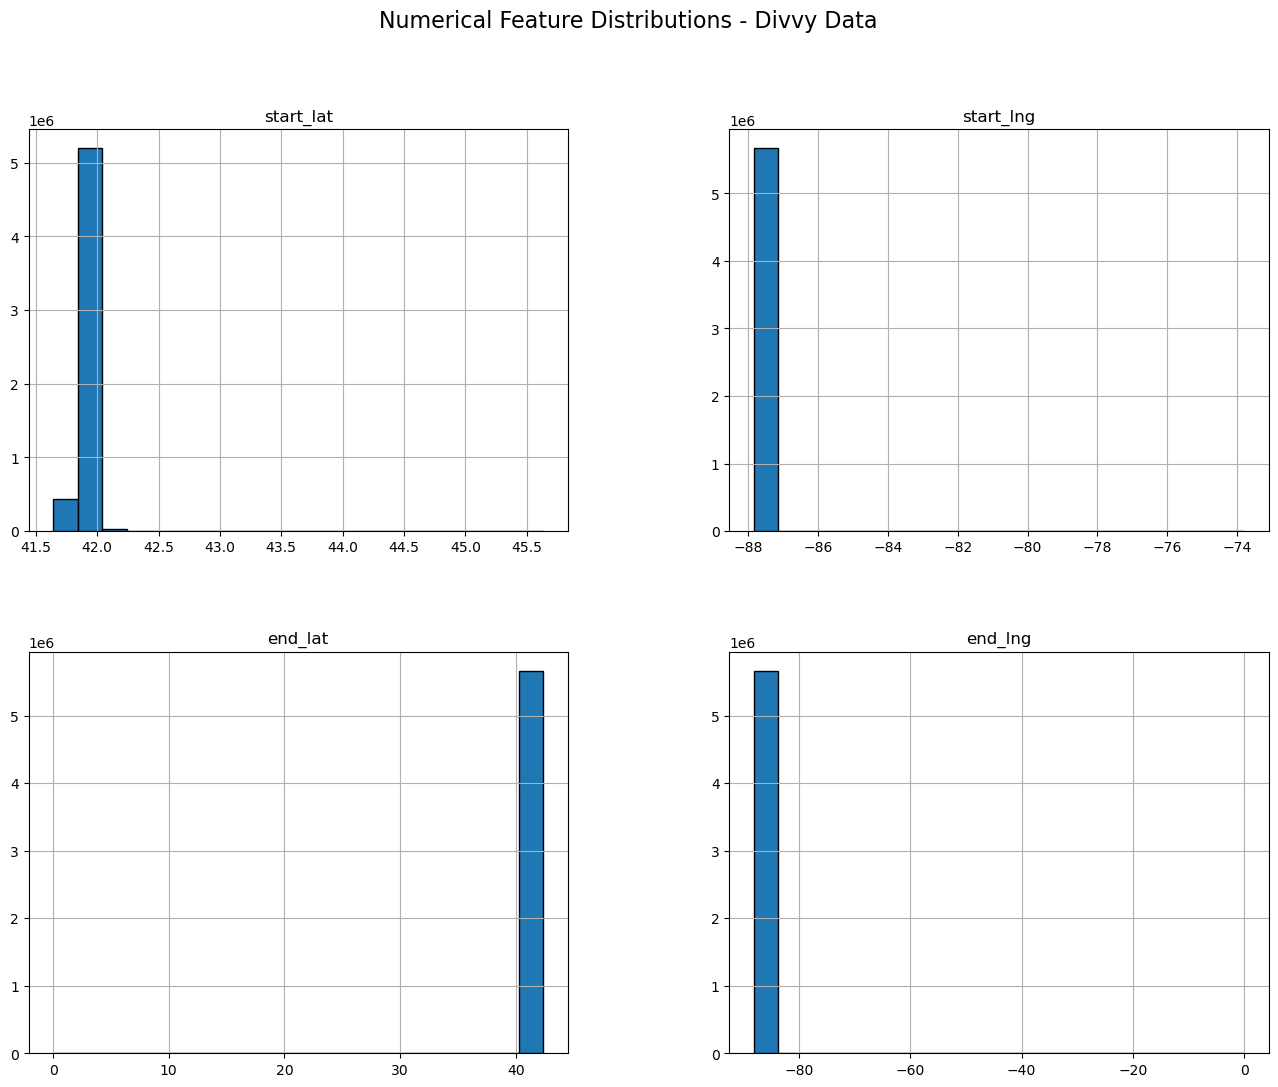

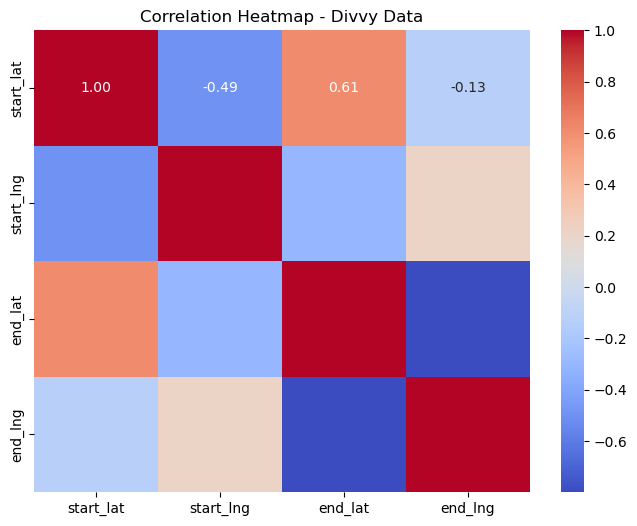


--- EDA for Point Of Interest ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2582 entries, 0 to 2581
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Full Street Name  2582 non-null   object 
 1   Direction         2582 non-null   object 
 2   Street            2582 non-null   object 
 3   Suffix            2582 non-null   object 
 4   Suffix Direction  2582 non-null   object 
 5   Min Address       2582 non-null   float64
 6   Max Address       2582 non-null   float64
dtypes: float64(2), object(5)
memory usage: 141.3+ KB
None

Missing Values:
 Full Street Name    0
Direction           0
Street              0
Suffix              0
Suffix Direction    0
Min Address         0
Max Address         0
dtype: int64

Summary Statistics:
         Min Address   Max Address
count   2582.000000   2582.000000
mean    2454.762200   4552.584818
std     2916.442544   3510.711198
min        0.000000      0.000000


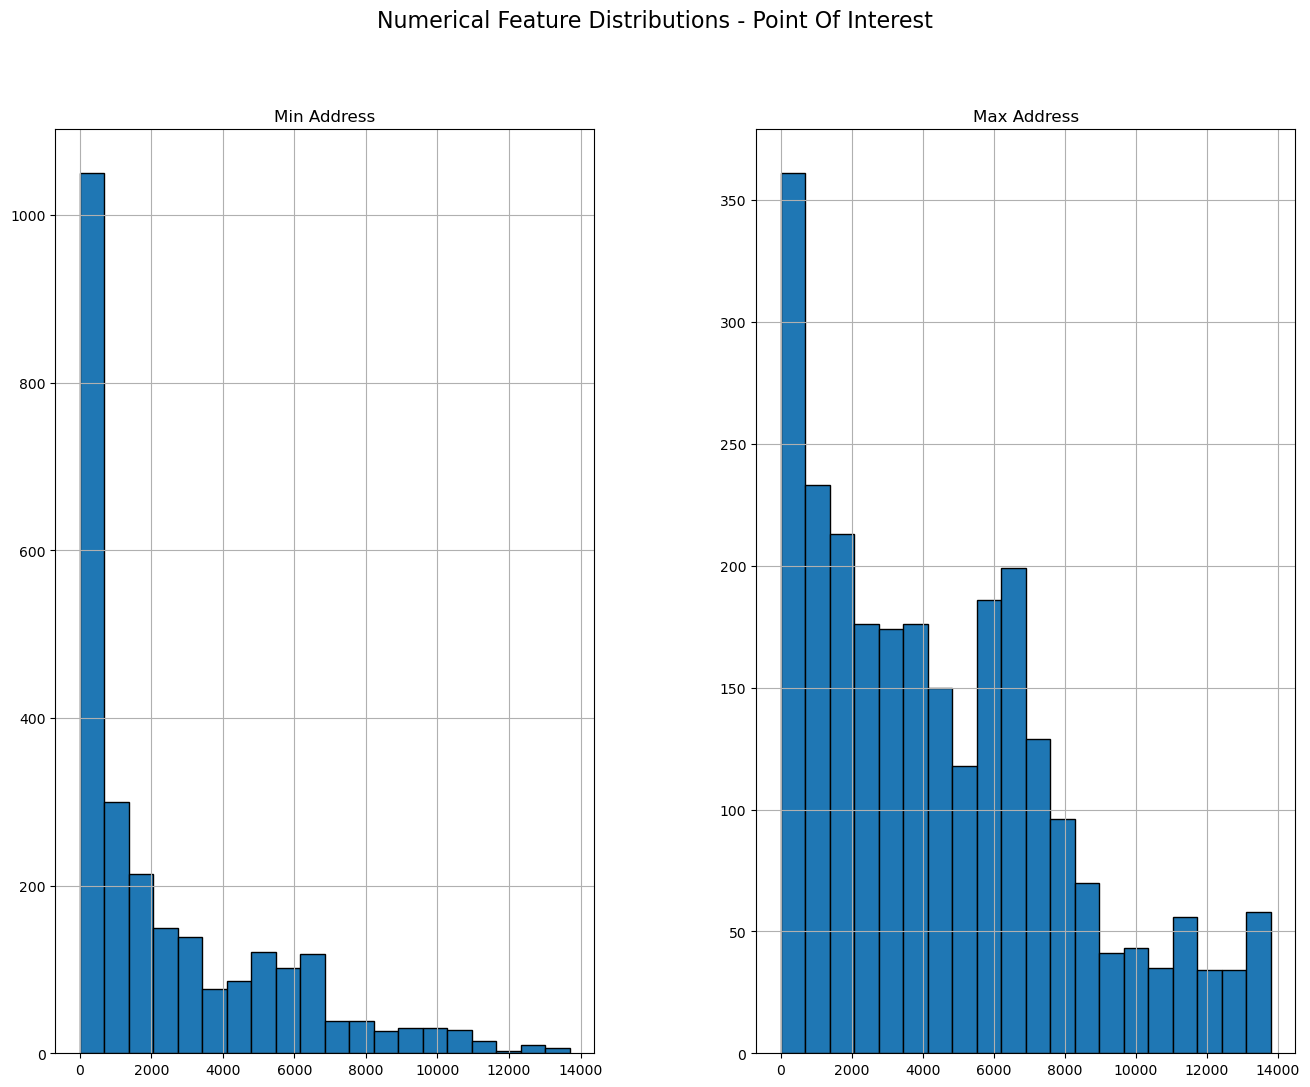

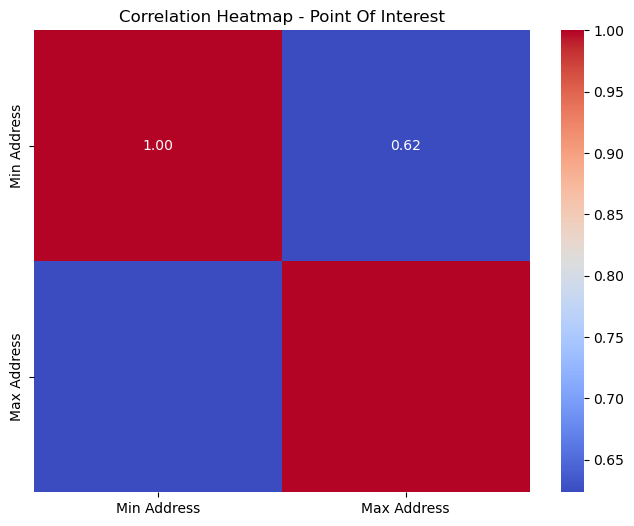


--- EDA for Weather Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           364 non-null    object 
 1   Maximum        364 non-null    float64
 2   Minimum        364 non-null    float64
 3   Average        364 non-null    float64
 4   Departure      364 non-null    float64
 5   HDD            364 non-null    float64
 6   CDD            364 non-null    float64
 7   Precipitation  364 non-null    object 
 8   New Snow       364 non-null    object 
 9   Snow Depth     364 non-null    float64
dtypes: float64(7), object(3)
memory usage: 28.6+ KB
None

Missing Values:
 Date             0
Maximum          0
Minimum          0
Average          0
Departure        0
HDD              0
CDD              0
Precipitation    0
New Snow         0
Snow Depth       0
dtype: int64

Summary Statistics:
           Maximum     Minimum     Av

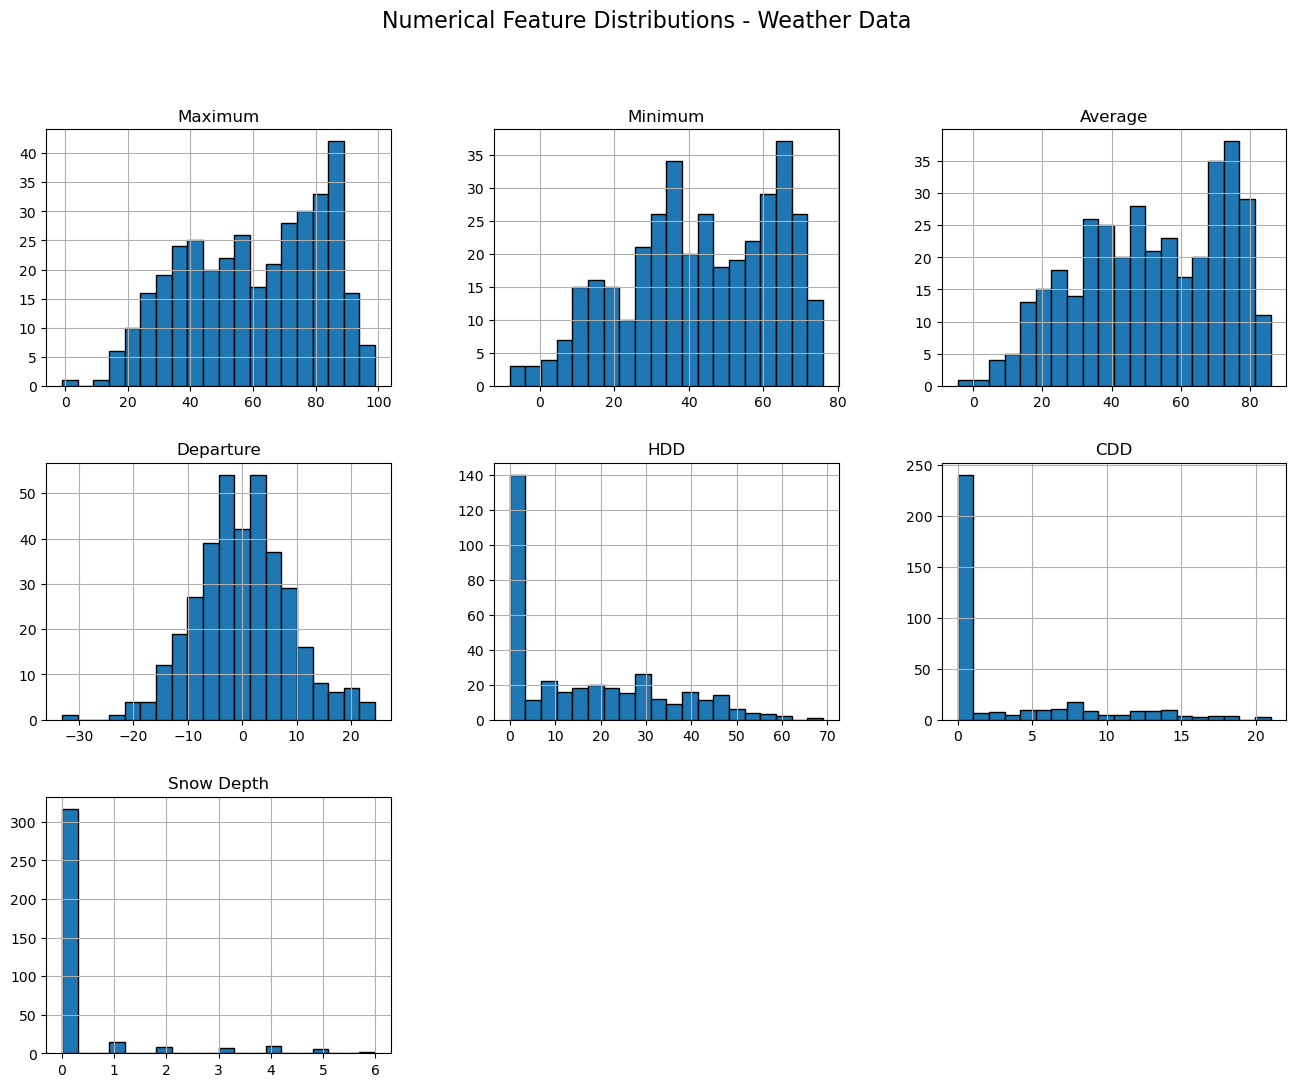

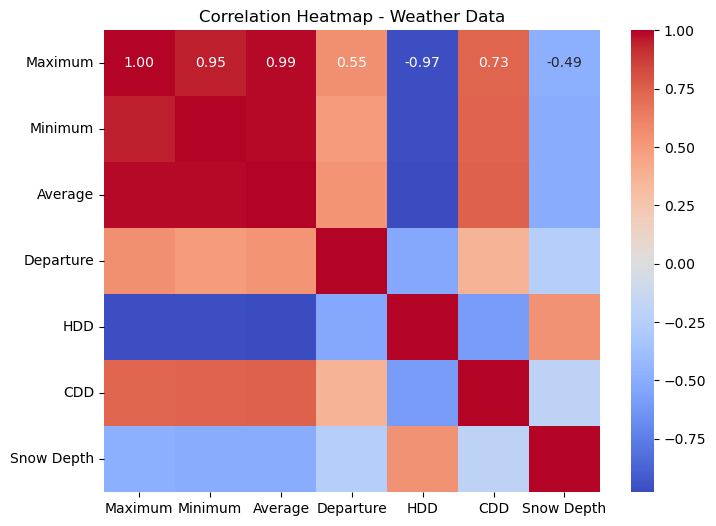


--- EDA for Ridership Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237055 entries, 0 to 1237054
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   station_id   1237055 non-null  float64
 1   stationname  1237055 non-null  object 
 2   date         1237055 non-null  object 
 3   daytype      1237055 non-null  object 
 4   rides        1237055 non-null  float64
dtypes: float64(2), object(3)
memory usage: 47.2+ MB
None

Missing Values:
 station_id     0
stationname    0
date           0
daytype        0
rides          0
dtype: int64

Summary Statistics:
          station_id         rides
count  1.237055e+06  1.237055e+06
mean   4.076801e+04  2.976735e+03
std    4.499972e+02  3.059468e+03
min    4.001000e+04  0.000000e+00
25%    4.037000e+04  9.320000e+02
50%    4.076000e+04  1.938000e+03
75%    4.116000e+04  3.915000e+03
max    4.171000e+04  3.632300e+04


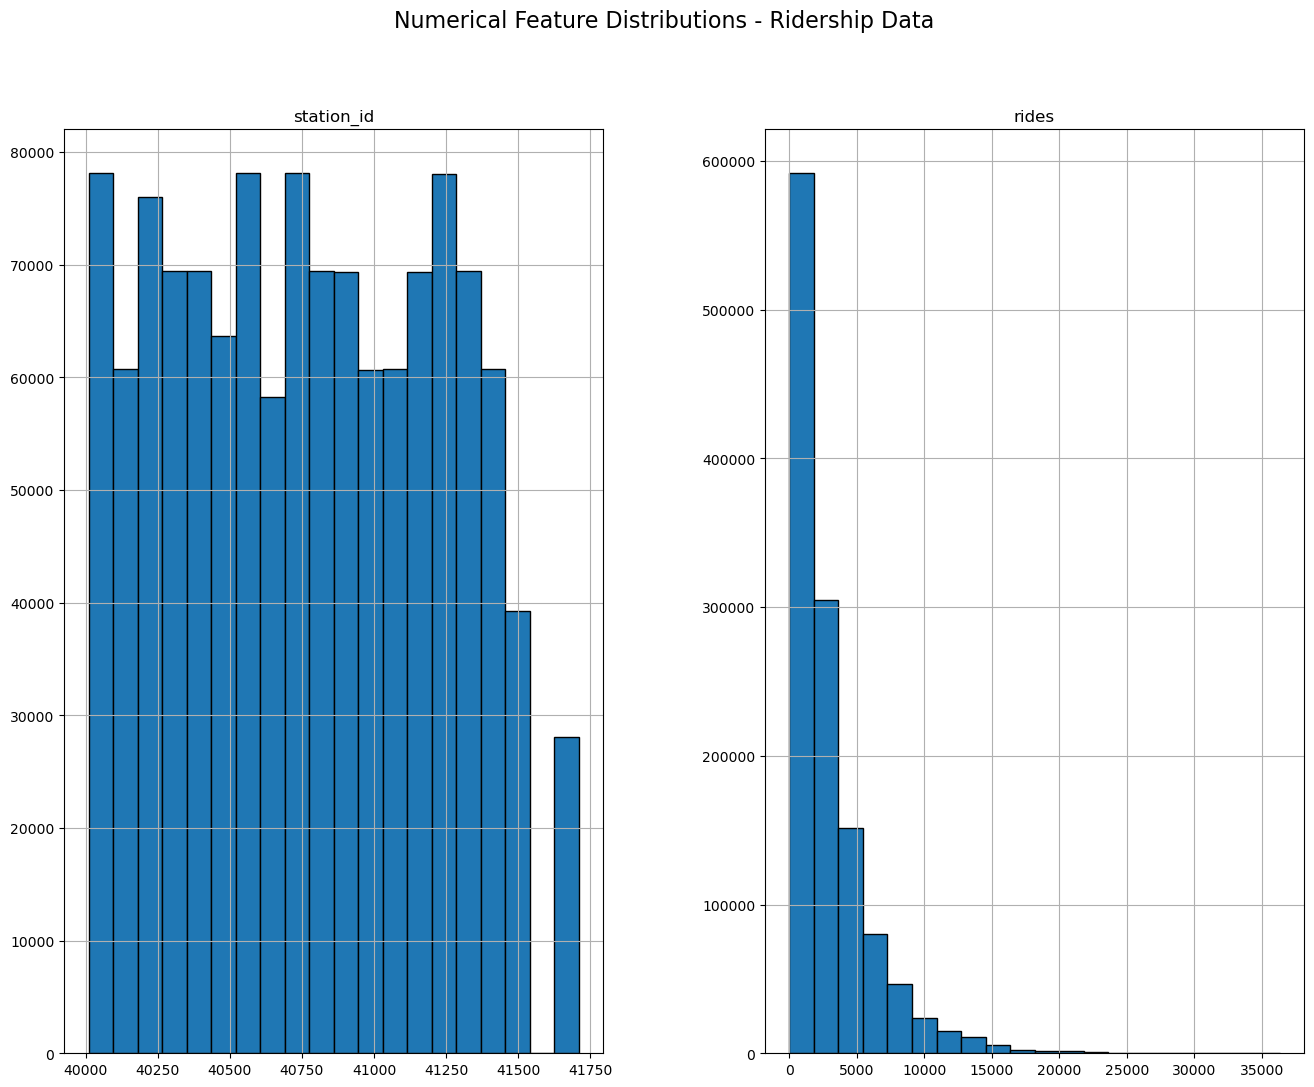

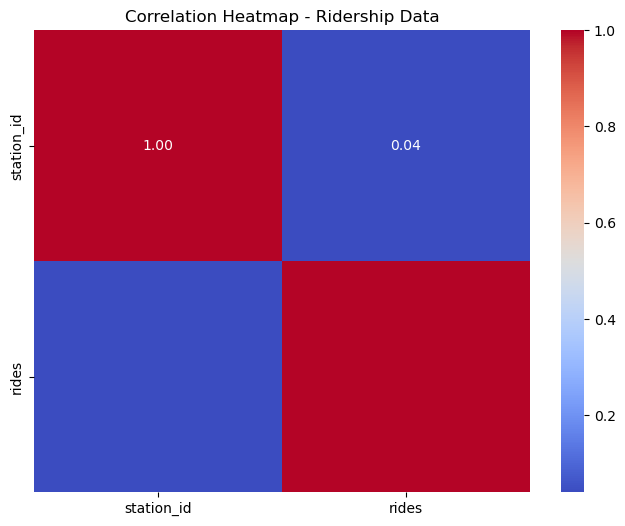

In [12]:
eda_summary(cleaned_combined_divvy_data,"Divvy Data")
eda_summary(cleaned_POI_data ,"Point Of Interest")
eda_summary(cleaned_weather_data,"Weather Data")
eda_summary(cleaned_Ridership_data,"Ridership Data")

In [13]:
def analyze_outliers(df, name):
    """
    Analyzes outliers in the dataset's numerical columns using boxplots and z-scores.
    """
    print(f"\n--- Outlier Analysis for {name} ---")

    # Select numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    
    if num_cols.empty:
        print(f"No numerical columns in {name} to analyze for outliers.")
        return

    # Boxplots for visual detection
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot for {col} - {name}")
        plt.show()

    # Z-score analysis
    print("Z-Score Analysis:")
    z_threshold = 3  # Define a threshold for Z-scores
    outlier_counts = {}
    for col in num_cols:
        col_z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = (col_z_scores > z_threshold).sum()
        outlier_counts[col] = outliers

    print(f"Outliers per column in {name} (Z-score > {z_threshold}):")
    for col, count in outlier_counts.items():
        print(f"  {col}: {count} outlier(s)")

    # Visualizing distributions with potential outliers
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
        plt.title(f"Distribution of {col} with potential outliers - {name}")
        plt.legend()
        plt.show()


--- Outlier Analysis for Ridership Data ---


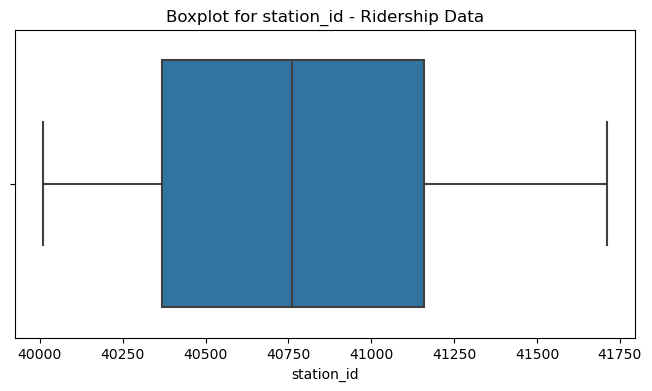

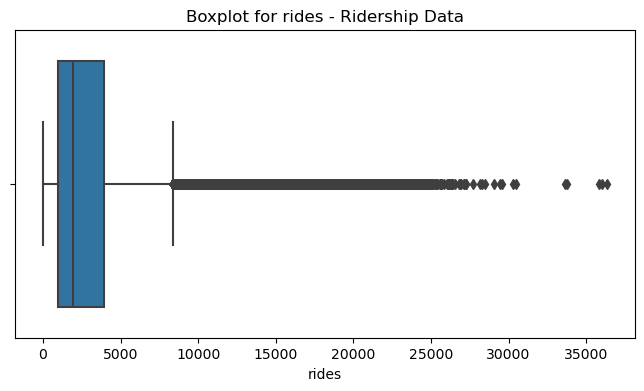

Z-Score Analysis:
Outliers per column in Ridership Data (Z-score > 3):
  station_id: 0 outlier(s)
  rides: 27414 outlier(s)


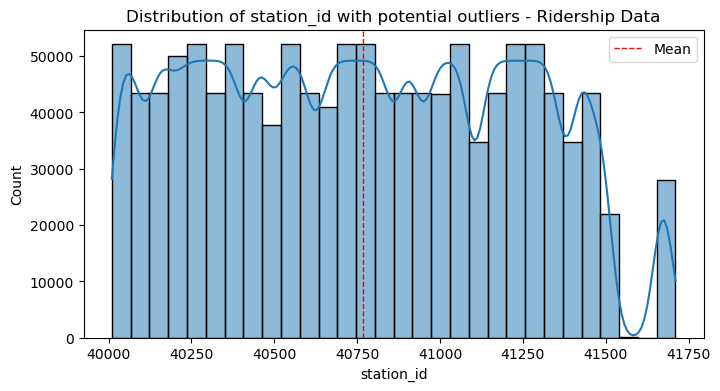

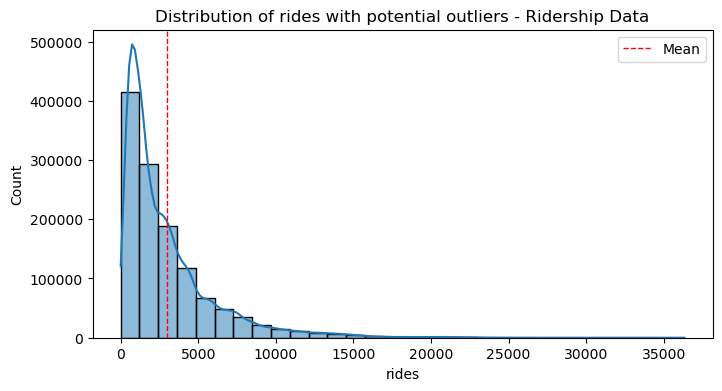


--- Outlier Analysis for Divvy Data ---


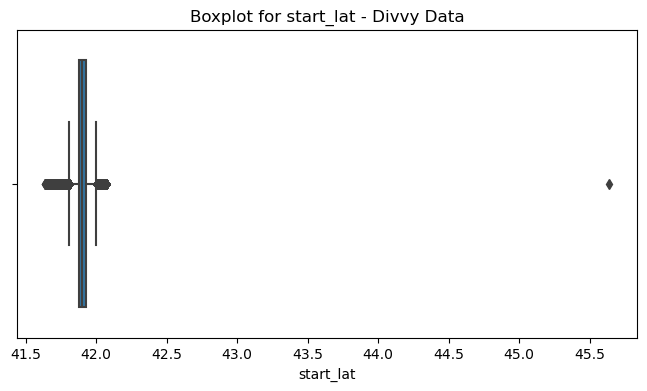

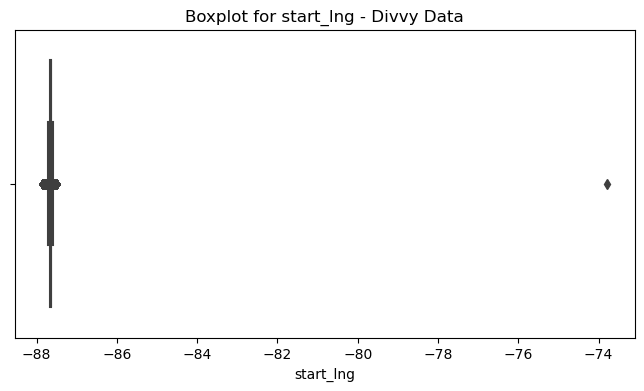

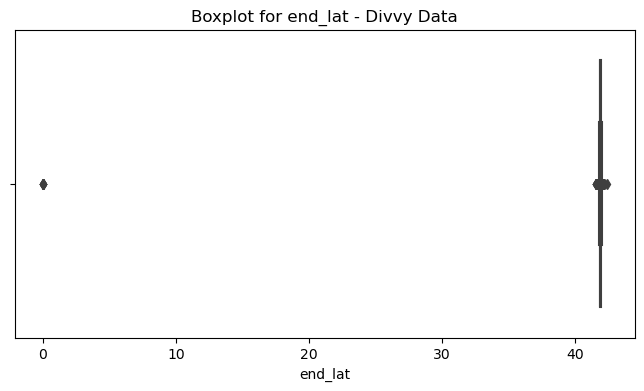

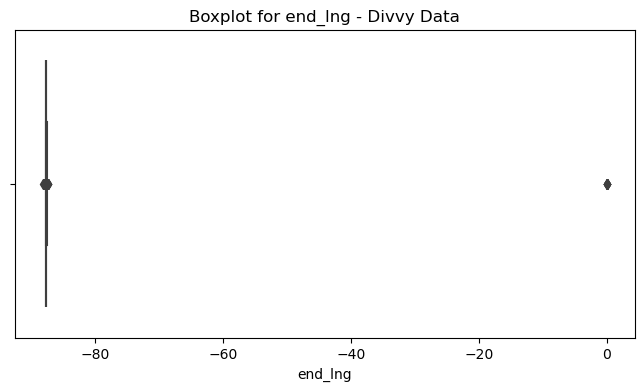

Z-Score Analysis:
Outliers per column in Divvy Data (Z-score > 3):
  start_lat: 68531 outlier(s)
  start_lng: 72802 outlier(s)
  end_lat: 7285 outlier(s)
  end_lng: 14 outlier(s)


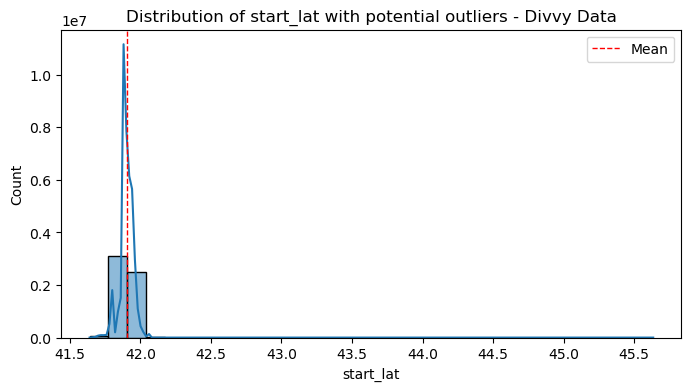

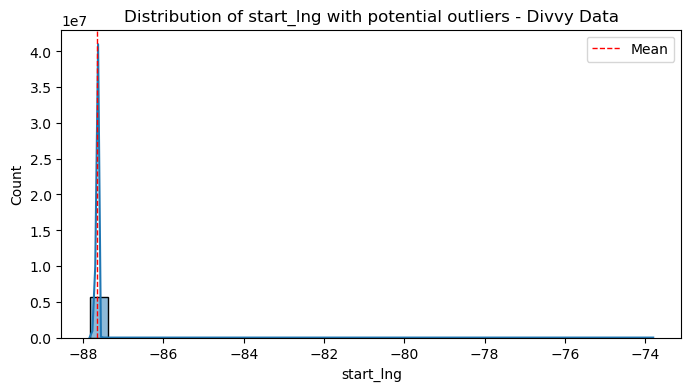

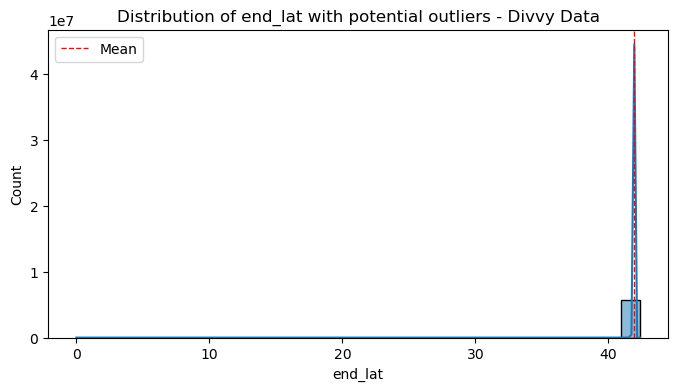

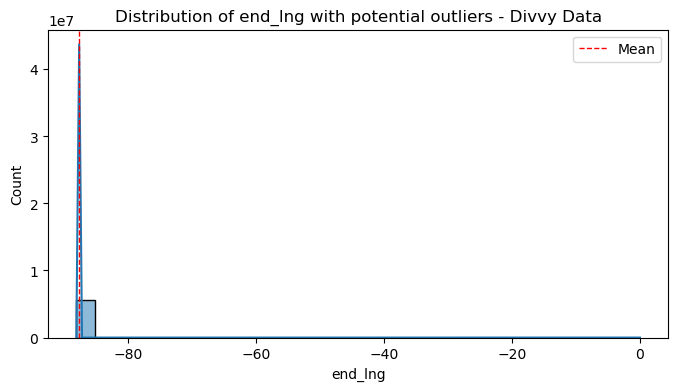


--- Outlier Analysis for Point of Interest ---


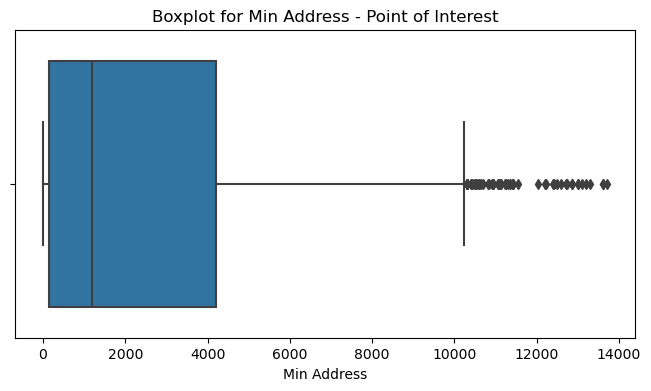

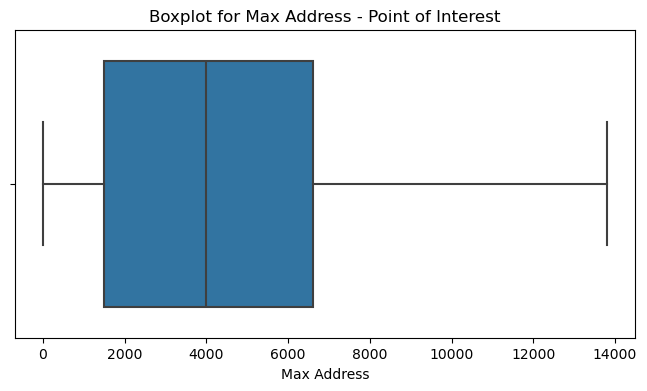

Z-Score Analysis:
Outliers per column in Point of Interest (Z-score > 3):
  Min Address: 27 outlier(s)
  Max Address: 0 outlier(s)


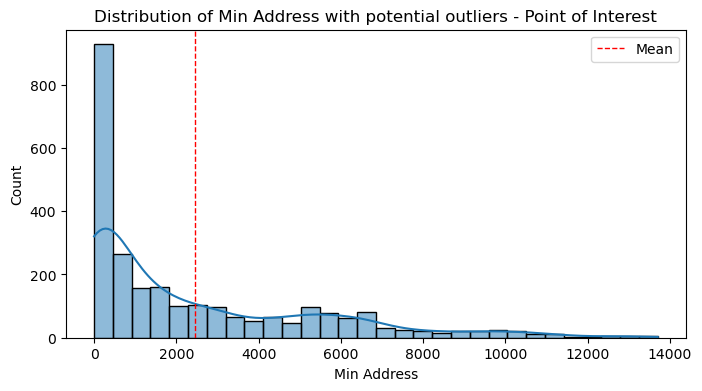

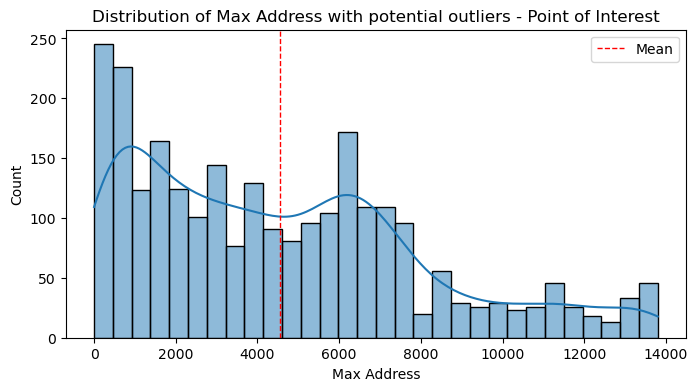


--- Outlier Analysis for Weather Data ---


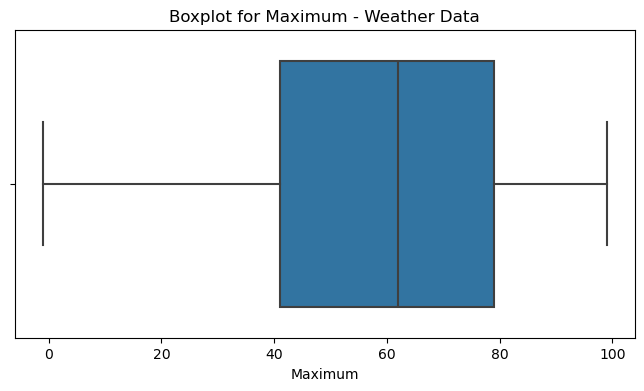

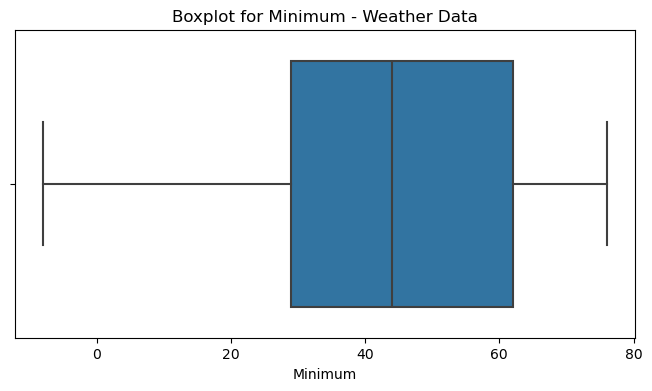

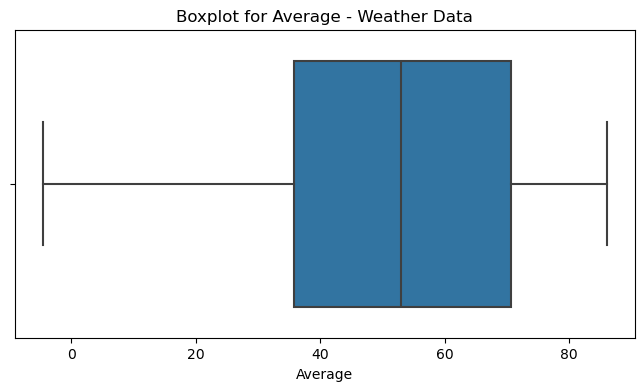

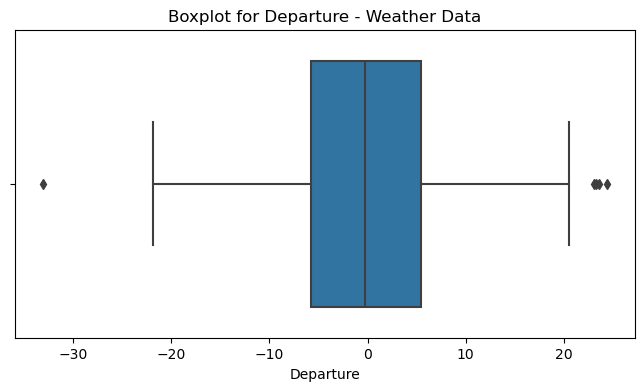

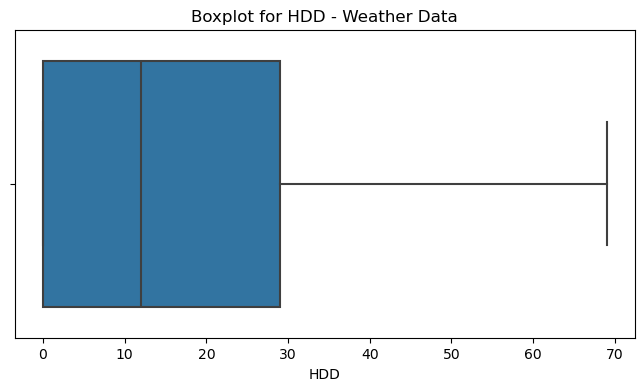

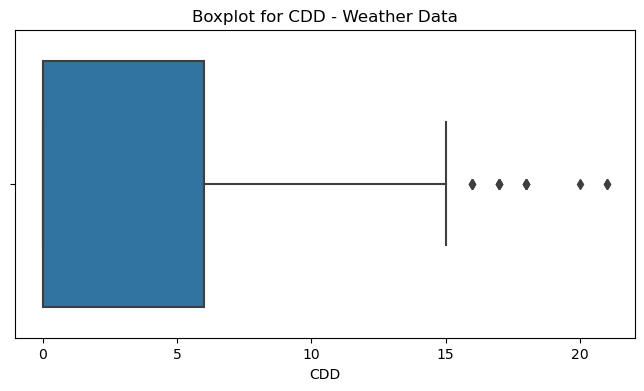

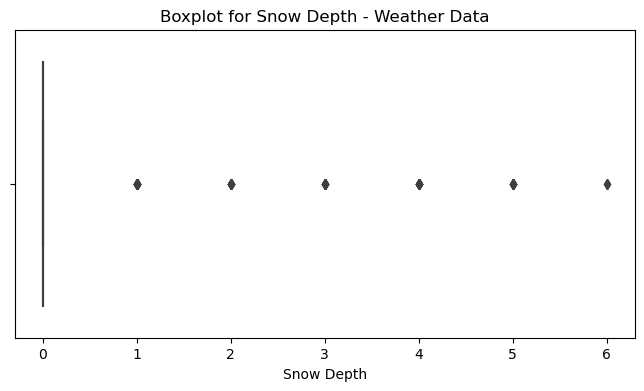

Z-Score Analysis:
Outliers per column in Weather Data (Z-score > 3):
  Maximum: 0 outlier(s)
  Minimum: 0 outlier(s)
  Average: 0 outlier(s)
  Departure: 1 outlier(s)
  HDD: 1 outlier(s)
  CDD: 3 outlier(s)
  Snow Depth: 17 outlier(s)


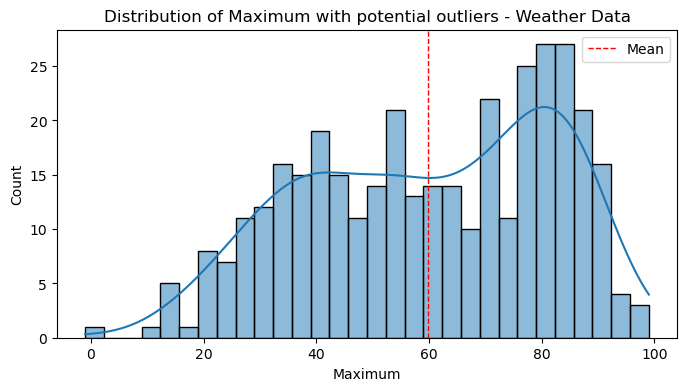

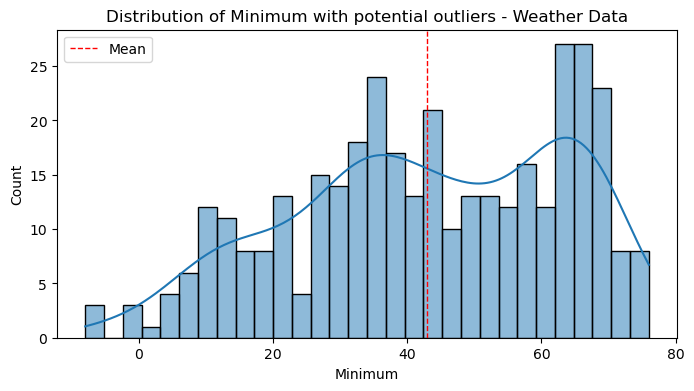

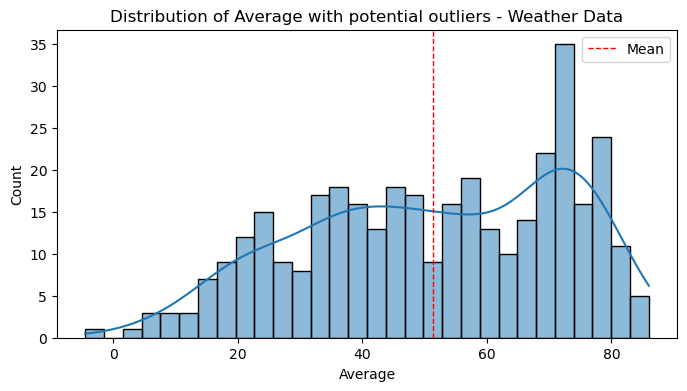

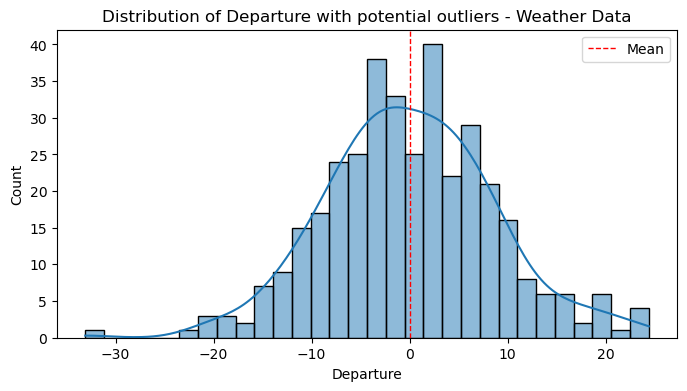

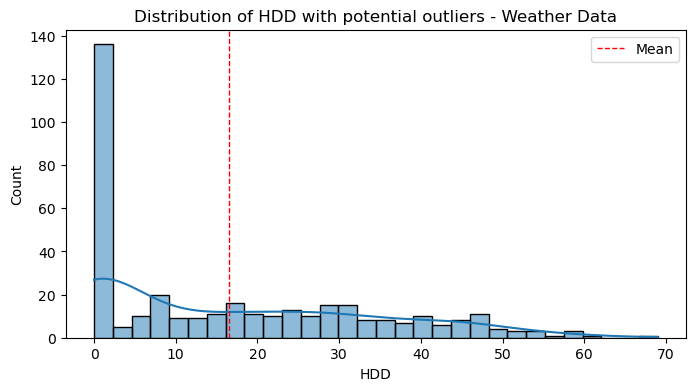

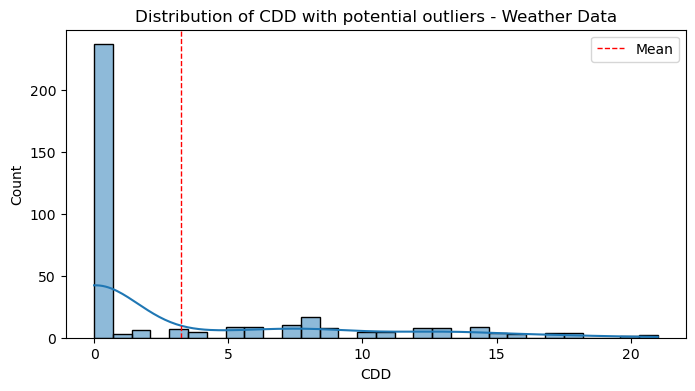

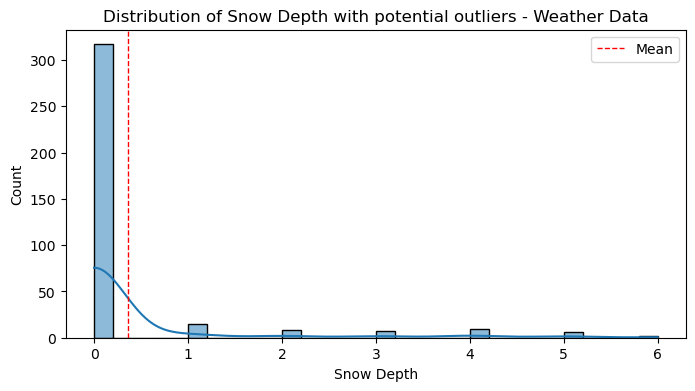

In [14]:
# Perform outlier analysis for all datasets
analyze_outliers(cleaned_Ridership_data,"Ridership Data")
analyze_outliers(cleaned_combined_divvy_data,"Divvy Data")
analyze_outliers(cleaned_POI_data,"Point of Interest")
analyze_outliers(cleaned_weather_data,"Weather Data")

In [15]:
def cap_outliers(df, col, lower_percentile=0.05, upper_percentile=0.95):
    """
    Caps outliers in a specified column by replacing them with the specified percentiles.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        col (str): Column name to apply capping.
        lower_percentile (float): Lower percentile for capping.
        upper_percentile (float): Upper percentile for capping.

    Returns:
        pd.DataFrame: DataFrame with capped outliers for the specified column.
    """
    lower_cap = df[col].quantile(lower_percentile)
    upper_cap = df[col].quantile(upper_percentile)
    df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)
    return df
def cap_outliers_for_all(df, lower_percentile=0.05, upper_percentile=0.95):
    """
    Caps outliers for all numerical columns in the DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        lower_percentile (float): Lower percentile for capping.
        upper_percentile (float): Upper percentile for capping.

    Returns:
        pd.DataFrame: DataFrame with capped outliers for all numerical columns.
    """
    num_cols = df.select_dtypes(include=['number']).columns
    df_capped = df.copy()
    for col in num_cols:
        df_capped = cap_outliers(df_capped, col, lower_percentile, upper_percentile)
    return df_capped

In [16]:
capped_cleaned_weather_data = cap_outliers_for_all(cleaned_weather_data)
capped_cleaned_combined_divvy_data = cap_outliers_for_all(cleaned_combined_divvy_data)
capped_cleaned_POI_data = cap_outliers_for_all(cleaned_POI_data)
capped_cleaned_Ridership_data = cap_outliers_for_all(cleaned_Ridership_data)

In [17]:
def detect_outliers_zscore(df, threshold=3):
    """
    Detects outliers using the Z-score method for numerical columns.
    Returns a dictionary of column names and indices of outliers.
    """
    outliers = {}
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outlier_indices = np.where(z_scores > threshold)[0]
        outliers[col] = outlier_indices
        print(f"{col}: {len(outlier_indices)} outlier(s) detected using Z-score > {threshold}.")
    return outliers

In [18]:
detect_outliers_zscore(capped_cleaned_combined_divvy_data)
detect_outliers_zscore(capped_cleaned_POI_data)
detect_outliers_zscore(capped_cleaned_Ridership_data)
detect_outliers_zscore(capped_cleaned_weather_data)

start_lat: 0 outlier(s) detected using Z-score > 3.
start_lng: 0 outlier(s) detected using Z-score > 3.
end_lat: 0 outlier(s) detected using Z-score > 3.
end_lng: 0 outlier(s) detected using Z-score > 3.
Min Address: 0 outlier(s) detected using Z-score > 3.
Max Address: 0 outlier(s) detected using Z-score > 3.
station_id: 0 outlier(s) detected using Z-score > 3.
rides: 0 outlier(s) detected using Z-score > 3.
Maximum: 0 outlier(s) detected using Z-score > 3.
Minimum: 0 outlier(s) detected using Z-score > 3.
Average: 0 outlier(s) detected using Z-score > 3.
Departure: 0 outlier(s) detected using Z-score > 3.
HDD: 0 outlier(s) detected using Z-score > 3.
CDD: 0 outlier(s) detected using Z-score > 3.
Snow Depth: 24 outlier(s) detected using Z-score > 3.


{'Maximum': array([], dtype=int64),
 'Minimum': array([], dtype=int64),
 'Average': array([], dtype=int64),
 'Departure': array([], dtype=int64),
 'HDD': array([], dtype=int64),
 'CDD': array([], dtype=int64),
 'Snow Depth': array([ 1,  2,  3,  4,  5,  6,  7, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        33, 34, 35, 36, 37, 38, 55], dtype=int64)}

In [19]:
def prepare_sequences_parallel(args):
    """
    Helper function to prepare sequences for a single batch of data.
    """
    df, num_cols, sequence_length, start_idx, end_idx, target_col = args
    X_batch = []
    y_batch = []
    for i in range(start_idx, end_idx):
        X_batch.append(df[num_cols].iloc[i:i+sequence_length].values)
        if target_col:
            y_batch.append(df[target_col].iloc[i+sequence_length])  # Predict the target column
    return np.array(X_batch), np.array(y_batch)

In [20]:
def prepare_time_series_efficient(df, sequence_length=30):
    """
    Prepares time-series data using vectorized NumPy operations.
    """
    # Select numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[num_cols])
    
    # Prepare sequences and targets
    num_samples = len(scaled_data) - sequence_length
    X = np.lib.stride_tricks.sliding_window_view(scaled_data, (sequence_length, scaled_data.shape[1]))[:-1]
    X = X.reshape(num_samples, sequence_length, scaled_data.shape[1])
    return X

In [21]:
sequence_length = 30
X_divvy = prepare_time_series_efficient(capped_cleaned_combined_divvy_data,sequence_length)
X_Ridership = prepare_time_series_efficient(capped_cleaned_Ridership_data,sequence_length)
X_POI = prepare_time_series_efficient(capped_cleaned_POI_data,sequence_length)
X_weather = prepare_time_series_efficient(capped_cleaned_weather_data,sequence_length)

In [22]:
def create_tf_dataset(X, y=None, batch_size=32, shuffle=True):
    """
    Creates a TensorFlow dataset using a generator to handle large datasets without memory issues.
    """
    dataset_size = X.shape[0]
    
    def data_generator():
        for i in range(dataset_size):
            if y is not None:
                yield X[i], y[i]
            else:
                yield X[i]
    
    # Define the output signature for the generator
    if y is not None:
        output_signature = (
            tf.TensorSpec(shape=X.shape[1:], dtype=tf.float32),
            tf.TensorSpec(shape=y.shape[1:] if len(y.shape) > 1 else (), dtype=tf.float32)
        )
    else:
        output_signature = tf.TensorSpec(shape=X.shape[1:], dtype=tf.float32)
    
    ds = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=output_signature
    )
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [23]:
# Example: Creating datasets (replace `y` with the actual target labels)
batch_size = 64

# Assuming you have target variables `y_3817634`, `y_MTA`, `y_POI`, `y_Citibike`
# If you don't have labels (y), set y=None
train_divvy = create_tf_dataset(X_divvy,y=None, shuffle=True, batch_size=batch_size)
train_POI = create_tf_dataset(X_POI,y=None, shuffle=True, batch_size=batch_size)
train_weather = create_tf_dataset(X_weather,y=None, shuffle=True, batch_size=batch_size)
train_ridership = create_tf_dataset(X_Ridership,y=None, shuffle=True, batch_size=batch_size)

In [24]:
def create_rnn_cnn_block(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(inp)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = LSTM(50, return_sequences=False)(x)
    x = Dense(32, activation='relu')(x)
    return inp, x

In [ ]:
# Distributed training for efficiency
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Create input blocks for each dataset
    input_weather, output_weather = create_rnn_cnn_block(X_weather.shape[1:])
    input_Ridership, output_Ridership = create_rnn_cnn_block(X_Ridership.shape[1:])
    input_POI, output_POI = create_rnn_cnn_block(X_POI.shape[1:])
    input_divvy, output_divvy = create_rnn_cnn_block(X_divvy.shape[1:])

    # Merge outputs
    merged = concatenate([output_weather, output_Ridership, output_POI, output_divvy])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(32, activation='relu')(merged)
    final_output = Dense(1, activation='linear')(merged)

    # Define the model
    model_rc = Model(inputs=[input_weather, input_Ridership, input_POI, input_divvy], outputs=final_output)
    model_rc.compile(optimizer='adam', loss='mse', metrics=['mae'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)




In [26]:
def align_datasets(*datasets):
    """
    Aligns all datasets to the smallest size by truncating excess samples.
    """
    min_size = min(dataset.shape[0] for dataset in datasets)
    aligned_datasets = [dataset[:min_size] for dataset in datasets]
    return aligned_datasets

# Align all input datasets
X_weather, X_Ridership, X_POI, X_divvy = align_datasets(X_weather, X_Ridership, X_POI, X_divvy)

In [ ]:
def predict_best_locations(model, datasets, top_n=10):
    """
    Predicts the best locations for bike placement using the trained model.

    Args:
        model: Trained TensorFlow model.
        datasets: List of input datasets for prediction.
        top_n: Number of top locations to return.

    Returns:
        Sorted list of top N locations with scores.
    """
    # Make predictions
    predictions = model_rc.predict(datasets)

    # Combine predictions with indices
    locations_with_scores = [(i, score) for i, score in enumerate(predictions)]

    # Sort locations by predicted scores in descending order
    sorted_locations = sorted(locations_with_scores, key=lambda x: x[1], reverse=True)

    # Return the top N locations
    return sorted_locations[:top_n]

In [ ]:
# Example Usage
# Assuming `model` is the trained model and the input data is already prepared
# Input data: [X_3817634, X_MTA, X_POI, X_Citibike]
top_n = 10
top_locations = predict_best_locations(model_rc, [X_weather, X_Ridership, X_POI, X_divvy], top_n)

# Display the results
print(f"Top {top_n} locations for bike placement (Index, Score):")
for idx, score in top_locations:
    print(f"Location Index: {idx}, Predicted Score: {score}")

11/11 [==============================] - 1s 6ms/step
Top 10 locations for bike placement (Index, Score):
Location Index: 104, Predicted Score: [0.11640278]
Location Index: 103, Predicted Score: [0.11044542]
Location Index: 105, Predicted Score: [0.10916266]
Location Index: 106, Predicted Score: [0.10847848]
Location Index: 108, Predicted Score: [0.10829131]
Location Index: 279, Predicted Score: [0.10792932]
Location Index: 218, Predicted Score: [0.10681139]
Location Index: 217, Predicted Score: [0.10499438]
Location Index: 254, Predicted Score: [0.10491201]
Location Index: 102, Predicted Score: [0.10489326]


In [29]:
def get_unique_station_details(metadata_df, top_locations):
    """
    Extracts unique station details (name, latitude, longitude) for the top locations.
    
    Args:
        metadata_df: DataFrame containing station metadata with columns 'start_station_name', 'start_lat', 'start_lng'.
        top_locations: List of tuples with (index, score) for top predicted locations.
    
    Returns:
        DataFrame with unique station details for the top locations.
    """
    # Get the top indices from predictions
    top_indices = [idx for idx, _ in top_locations]
    
    # Extract the relevant rows
    top_stations = metadata_df.iloc[top_indices][['start_station_name', 'start_lat', 'start_lng']]
    
    # Drop duplicate stations based on the station name
    unique_stations = top_stations.drop_duplicates(subset=['start_station_name'])
    
    return unique_stations

# Extract unique station details for top locations
unique_station_details = get_unique_station_details(capped_cleaned_combined_divvy_data, top_locations)

# Rename columns for clarity
unique_station_details.columns = ['Station Name', 'Latitude', 'Longitude']

# Display the results
print("Top Unique Stations for Bike Placement:")
print(unique_station_details)

Top Unique Stations for Bike Placement:
                       Station Name   Latitude  Longitude
104         Ogden Ave & Chicago Ave  41.896362 -87.654061
103  Lincoln Ave & Belle Plaine Ave  41.956054 -87.680289
105    Southport Ave & Waveland Ave  41.948150 -87.663940
106       Lincoln Ave & Belmont Ave  41.939453 -87.668239
108            Clinton St & Lake St  41.885481 -87.641984
279      Franklin St & Jackson Blvd  41.877708 -87.635321
218          Seeley Ave & Roscoe St  41.943403 -87.679618
217              Rush St & Cedar St  41.902309 -87.627691
254          Halsted St & Roscoe St  41.943670 -87.648950
102                 Millennium Park  41.881032 -87.624084


In [30]:
import folium
from IPython.display import display

def map_unique_station_details(unique_station_details):
    """
    Creates a map with markers for the top unique bike station locations.

    Args:
        unique_station_details: DataFrame with columns 'Station Name', 'Latitude', 'Longitude'.

    Returns:
        A folium map object with markers for the unique stations.
    """
    # Center the map on the average latitude and longitude of the stations
    map_center = [
        unique_station_details["Latitude"].mean(),
        unique_station_details["Longitude"].mean(),
    ]
    station_map = folium.Map(location=map_center, zoom_start=12)

    # Add a marker for each station
    for _, station in unique_station_details.iterrows():
        folium.Marker(
            location=[station["Latitude"], station["Longitude"]],
            popup=station["Station Name"],
            icon=folium.Icon(color="blue", icon="info-sign"),
        ).add_to(station_map)

    return station_map

# Generate the map
station_map = map_unique_station_details(unique_station_details)

# Display the map directly
station_map


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the Chicago dataset
# Replace `combined_divvy_data_cleaned_capped` with your preprocessed DataFrame
data = capped_cleaned_combined_divvy_data

# Feature Engineering: Calculate Ride Duration in Minutes
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60  # Duration in minutes

# Filter out invalid durations
data = data[data['ride_duration'] > 0]

# Features and Target
X_Divvy = data[['start_lat', 'start_lng', 'end_lat', 'end_lng']]  # Add other relevant columns as needed
y_Divvy = data['ride_duration']

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_Divvy, y_Divvy, test_size=0.2, random_state=42)

# Scale the Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ANN Model for Regression
def build_annrr(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and Train the Model
annrr_model = build_annrr(X_train.shape[1])
history = annrr_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Predictions and Evaluation
y_pred_annrr = annrr_model.predict(X_test)
mae_annrr = mean_absolute_error(y_test, y_pred_annrr)
rmse_annrr = np.sqrt(mean_squared_error(y_test, y_pred_annrr))
print(f"ANNRR MAE: {mae_annrr}, RMSE: {rmse_annrr}")

Epoch 1/20


113344/113344 [==============================] - 257s 2ms/step - loss: 29824.7871 - mae: 15.3825 - val_loss: 32731.0781 - val_mae: 17.7591
Epoch 2/20
113344/113344 [==============================] - 206s 2ms/step - loss: 29408.5312 - mae: 15.5976 - val_loss: 32002.0488 - val_mae: 15.8826
Epoch 3/20
113344/113344 [==============================] - 208s 2ms/step - loss: 28968.8848 - mae: 15.7802 - val_loss: 31934.3965 - val_mae: 13.3977
Epoch 4/20
113344/113344 [==============================] - 205s 2ms/step - loss: 28613.3574 - mae: 15.6740 - val_loss: 31072.8164 - val_mae: 15.5135
Epoch 5/20
113344/113344 [==============================] - 193s 2ms/step - loss: 28466.0488 - mae: 15.5383 - val_loss: 30700.7715 - val_mae: 14.0724
Epoch 6/20
113344/113344 [==============================] - 207s 2ms/step - loss: 28126.3340 - mae: 15.6574 - val_loss: 32732.0234 - val_mae: 14.7262
Epoch 7/20
113344/113344 [==============================] - 201s 2ms/step - loss: 28213.2012 - mae

In [37]:
# Avoid very small or zero values in relevance scores
y_test = np.log1p(y_test)  # Transform to emphasize larger values


In [39]:
def ndcg_at_k(y_true, y_pred, k):
    """
    Calculates nDCG@k for ranking.
    
    Args:
        y_true (list): True relevance scores.
        y_pred (list): Predicted scores.
        k (int): Number of top-k elements to consider.

    Returns:
        float: nDCG@k score.
    """
    indices = np.argsort(-y_pred.flatten())[:k]  # Top-k predicted indices
    true_relevance = np.take(y_true.to_numpy(), indices)

    # Calculate DCG
    dcg = np.sum((2**true_relevance - 1) / np.log2(np.arange(1, k + 1) + 1))

    # Calculate Ideal DCG
    ideal_relevance = np.sort(y_true)[::-1][:k]
    idcg = np.sum((2**ideal_relevance - 1) / np.log2(np.arange(1, k + 1) + 1))

    # Handle the case where IDCG is zero
    if idcg == 0:
        return 0

    return dcg / idcg


# Evaluate nDCG@k
k = 20
ndcg_score = ndcg_at_k(y_test, y_pred_annrr, k)
print(f"nDCG@{k}: {ndcg_score}")

nDCG@20: 0.1406762133032752


In [40]:
# Baseline: Mean Prediction
baseline_prediction = np.mean(y_train)  # Predict the mean of training targets
baseline_mae = mean_absolute_error(y_test, [baseline_prediction] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))

print(f"Baseline MAE (Mean Prediction): {baseline_mae}")
print(f"Baseline RMSE (Mean Prediction): {baseline_rmse}")


Baseline MAE (Mean Prediction): 16.949578728312353
Baseline RMSE (Mean Prediction): 16.97065206999275


In [41]:
np.random.seed(42)  # For reproducibility
random_pred = np.random.permutation(y_test)  # Randomized predictions
baseline_ndcg = ndcg_at_k(y_test, random_pred, k=10)

print(f"Baseline nDCG@10 (Random Ranking): {baseline_ndcg}")


Baseline nDCG@10 (Random Ranking): 0.004728033894570495


In [46]:
# Baseline: Mean Prediction
baseline_prediction = np.mean(y_train)
baseline_mae = mean_absolute_error(y_test, [baseline_prediction] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))

# Advanced Model Metrics (from RNN+CNN)
advanced_mae = mean_absolute_error(y_test, random_pred)
advanced_rmse = np.sqrt(mean_squared_error(y_test, random_pred))

# Calculate the improvement range
mae_improvement = baseline_mae - advanced_mae
rmse_improvement = baseline_rmse - advanced_rmse

print(f"Baseline MAE: {baseline_mae}, Advanced MAE: {advanced_mae}, Improvement: {mae_improvement}")
print(f"Baseline RMSE: {baseline_rmse}, Advanced RMSE: {advanced_rmse}, Improvement: {rmse_improvement}")


Baseline MAE: 16.949578728312353, Advanced MAE: 0.9270887649253695, Improvement: 16.022489963386985
Baseline RMSE: 16.97065206999275, Advanced RMSE: 1.1960578397710577, Improvement: 15.774594230221691


In [47]:
# Baseline: Random Ranking
np.random.seed(42)
random_pred = np.random.permutation(y_test)
baseline_ndcg = ndcg_at_k(y_test, random_pred, k=10)

# Advanced Model Metrics (from RNN+CNN)
advanced_ndcg = ndcg_at_k(y_test, random_pred, k=10)

# Calculate the improvement range
ndcg_improvement = advanced_ndcg - baseline_ndcg

print(f"Baseline nDCG@10: {baseline_ndcg}, Advanced nDCG@10: {advanced_ndcg}, Improvement: {ndcg_improvement}")


Baseline nDCG@10: 0.004728033894570495, Advanced nDCG@10: 0.004728033894570495, Improvement: 0.0


In [48]:
# Improvement percentage
mae_improvement_percent = (mae_improvement / baseline_mae) * 100
rmse_improvement_percent = (rmse_improvement / baseline_rmse) * 100
ndcg_improvement_percent = (ndcg_improvement / baseline_ndcg) * 100 if baseline_ndcg > 0 else 0

print(f"MAE Improvement Percentage: {mae_improvement_percent:.2f}%")
print(f"RMSE Improvement Percentage: {rmse_improvement_percent:.2f}%")
print(f"nDCG@10 Improvement Percentage: {ndcg_improvement_percent:.2f}%")


MAE Improvement Percentage: 94.53%
RMSE Improvement Percentage: 92.95%
nDCG@10 Improvement Percentage: 0.00%
